In [1]:
%pip install spacy

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import sys
sys.path.insert(0, '../src/')
import pandas as pd
import spacy
from collections import defaultdict
# from data_cleaning import split_df, df_lang
from data_transformation import get_X_y, distribution
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Perceptron
from sklearn.preprocessing import OneHotEncoder


## 1. Data Collection

We begin by scrapping Wiktionary.org for *feminine*, *masculine*, and *neuter* nouns in *Polish*, *German*, *Spanish*, and *French*.


In [3]:
# run webscrapper

## 2. Data Cleaning

The raw data in json format must be cleaned: removing nouns with *spaces*, *hyphens*, *numbers*, *abbreviations*, *initials* and finally those that are *proper nouns*.

### 2.1 Read data

In [4]:
# read json file and load it as a DataFrame
path = '../data/raw_scraped_data.json'
raw_df = pd.read_json(path)
raw_df

,noun,gender,lang
0,a,masculine,Polish
1,Aalborg,masculine,Polish
2,aalen,masculine,Polish
3,Aarhus,masculine,Polish
4,abacysta,masculine,Polish
...,...,...,...
328184,zurrona,feminine,Spanish
328185,zutana,feminine,Spanish
328186,zwingliana,feminine,Spanish
328187,zwingliana,feminine,Spanish


### 2.2 Initial filter

In [5]:
# remove numbers, hypens, spaces, and periods
no_nums = raw_df[(~raw_df['noun'].str.contains('-| |\.|1|2|3|4|5|6|7|8|9|0'))]
print(no_nums.shape)
# remove full uppercase
no_caps = no_nums[(~no_nums['noun'].str.isupper())]
print(no_caps.shape)


(301257, 3)
(299192, 3)


### 2.3 Further cleaning

Break df into each language to: 
- remove duplicates in each language
- remove nouns that begin with a capital letter (except for German) 

In [6]:
from typing import List, Tuple
from spacy.language import Language
from collections import namedtuple


def df_lang(df: pd.DataFrame)-> List[Tuple[str, pd.DataFrame]]:
    """
    Splits main df by 'lang' column, and creates new sub
    dataFrames

    returns:
        list: namedtuple (lang, df)
    """
    Sub_df = namedtuple('Sub_df', ['lang', 'df'])
    languages = df['lang'].unique()
    dataframes = [df[df['lang'] == lang] for lang in languages]
    return [Sub_df(lang, sub_df) for lang, sub_df in zip(languages, dataframes)]

In [7]:
spacy.load("de_core_news_sm")

# separate df for each language
dfs = df_lang(no_caps)

# remove nouns that begin with captial letters (except German)
temp = []
for sub_df in dfs:
    if sub_df.lang != 'German':
        temp.append(sub_df.df[~sub_df.df['noun'].str.istitle()])
    else: # otherwise, for German, pass into SpaCy and filter out Proper nouns
        words = pd.Series(sub_df.df['noun']).tolist()
        nlp = spacy.load("de_core_news_sm")
        text = " ".join(words) 
        nlp.max_length = len(text) 
        doc = nlp(text) 
        tokens = [token.text for token in doc if token.pos_ != 'PROPN']
        temp.append(sub_df.df[sub_df.df['noun'].isin(tokens)])
clean = pd.concat(temp)

In [8]:
clean

,noun,gender,lang
0,a,masculine,Polish
2,aalen,masculine,Polish
4,abacysta,masculine,Polish
5,abak,masculine,Polish
7,abakawir,masculine,Polish
...,...,...,...
328184,zurrona,feminine,Spanish
328185,zutana,feminine,Spanish
328186,zwingliana,feminine,Spanish
328187,zwingliana,feminine,Spanish


## 3 Transform and Encode data
#### 3.1 Create function to add # to all nouns
Make all nouns the same length, this is done by preprending '#' to nouns until they are a uniform length


In [9]:
# get length of longest noun
max_length = clean['noun'].str.len().max() # 38

def add_filler(word):
    """ preprends n amount #'s to a word 
    based on a max_length"""
    if len(word) < max_length: # if word len() is less than the max len()
        diff = max_length - len(word) # we subtract the current word len() by the max len(): diff
        return '#' * diff + word # we prepend n(diff) amount of '#'s to the word and then return it
    return word # if len() of word is NOT less then the max len, then just return it

# apply function to every value in column 'noun'
clean['noun'] = clean['noun'].apply(add_filler)
print(clean.head(5))

                                     noun     gender    lang
0  #####################################a  masculine  Polish
2  #################################aalen  masculine  Polish
4  ##############################abacysta  masculine  Polish
5  ##################################abak  masculine  Polish
7  ##############################abakawir  masculine  Polish


#### 3.2 
get a distribution of all languages and genders and get the lowest count

In [10]:
grouped = clean.groupby(['gender','lang']).size().unstack()
lowest_value = int(grouped.min().min())
print(distribution(clean))
print('lowest_value = ', lowest_value)


lang       French  German  Polish   Spanish
gender                                     
feminine   3801.0  3624.0  2555.0  116375.0
masculine  3911.0  2485.0  2681.0  119263.0
neuter        NaN  2392.0  4883.0       NaN
lowest_value =  2392


### 3.3 Reduce all language sub dfs and genders to a uniform amount (lowest_value)

In [11]:
reduced_df = clean.groupby(['lang', 'gender'])[['noun', 'gender', 'lang']].sample(n=lowest_value) # reduce each language and gender by lowest_value
print(distribution(reduced_df))
reduced_df.shape

lang       French  German  Polish  Spanish
gender                                    
feminine   2392.0  2392.0  2392.0   2392.0
masculine  2392.0  2392.0  2392.0   2392.0
neuter        NaN  2392.0  2392.0      NaN


(23920, 3)

#### 3.3 Define an encoding function
aim is to grab n amount of letters in a noun (starting from the end), and passing it into a one-hot encoder that will represent said letter(s) as a vector.
1. grab n amount of letters from each noun (this will be encoded)
2. intialize an encoder
3. encode n amount of letters
4. convert results into a dataframe (transformed df)
5. re index reduced df
6. return new dataframe which is made of : reduced df and transformed df

In [12]:
def encode(reduced_df, n=0):
    to_be_encoded = reduced_df['noun'].str[-n:] # grab n amount of letters start from the end to encode only
    ohe = OneHotEncoder(sparse_output=False) # initialize the encoder
    transformed = ohe.fit_transform(to_be_encoded.to_numpy().reshape(-1, 1)) # encode
    transformed_df = pd.DataFrame(transformed) # convert to a dataframe
    reduced_df.reset_index(inplace=True, drop=True) # reset indexes
    return pd.concat([reduced_df, transformed_df], axis=1) # create new dataframe of reduced df and transformed df

## 4 Train, test, fit, score

#### 4.1 create function to train,fit, test all languages with n amount of encoding



In [13]:
def multi_train_per_lang(df):
    results = defaultdict(lambda :defaultdict(list)) # to store scores from ML Models. dict->dict->list
    max_length = df['noun'].str.len().max() # get longest noun in whole dataset
    dfs = df_lang(df) # break df into smalled dfs based on language: spanish_df, french_df etc
    
    for sub_df in dfs: # for each language df
        for n in range(1, max_length + 1): # 
            encoded_df = encode(sub_df.df, n) # encode n amount of letters for the ith langauge df
            X, y = get_X_y(encoded_df) # X is the vector representationf for n amount of letters, y are the labels
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

            # now that we have a train test split, we can plug them into our ML models
            # KNN
            knn = KNeighborsClassifier(n_neighbors=3) # initialize a KNN class, 3 neighbors
            knn.fit(X_train, y_train) # train it 
            results['KNN'][n].append((knn.score(X_test, y_test), sub_df.lang)) # append score into results dict, along with name of sub df (French, German, etc)

            # Perceptron
            p = Perceptron(random_state=42) # initialize a Perceptron class, random state 42
            p.fit(X_train, y_train) # train it
            results['Perceptron'][n].append((p.score(X_test, y_test), sub_df.lang)) # append score to results dict, along with name of sub df (French, German, etc)

    return results # return s scores of l sub dfs in df, of n amount of letters encode, for c amount of ML models. Ex: results[c][n]: (s,l)

## 4.2 Experiment 1: train and test each language individually on n amount of letters encoded 
## takes ~5 mins to run!!

In [14]:
all_langs = multi_train_per_lang(reduced_df)
all_langs

defaultdict(<function __main__.multi_train_per_lang.<locals>.<lambda>()>,
            {'KNN': defaultdict(list,
                         {1: [(0.7001044932079414, 'French'),
                           (0.6239554317548747, 'German'),
                           (0.9303621169916435, 'Polish'),
                           (0.8275862068965517, 'Spanish')],
                          2: [(0.8181818181818182, 'French'),
                           (0.7388579387186629, 'German'),
                           (0.9575208913649025, 'Polish'),
                           (0.8495297805642633, 'Spanish')],
                          3: [(0.864158829676071, 'French'),
                           (0.8105849582172702, 'German'),
                           (0.9066852367688022, 'Polish'),
                           (0.8265412748171369, 'Spanish')],
                          4: [(0.8683385579937304, 'French'),
                           (0.7924791086350975, 'German'),
                           (0.788300835654596

### 4.3 Show results for KNN

In [15]:
knn_results = all_langs['KNN']
knn_df = pd.DataFrame.from_dict(knn_results, orient="index", columns=['Polish', 'German', 'French', 'Spanish'])
knn_iterative_df = knn_df.applymap(lambda x: x[0]) # grab first element in the tuple (score, langauage)
knn_iterative_df.to_csv('../data/knn_per_language_results.csv') # save to csv
knn_iterative_df # display dataframe

,Polish,German,French,Spanish
1,0.700104,0.623955,0.930362,0.827586
2,0.818182,0.738858,0.957521,0.849530
3,0.864159,0.810585,0.906685,0.826541
4,0.868339,0.792479,0.788301,0.693835
5,0.628004,0.658774,0.804318,0.594566
6,0.690700,0.556407,0.663649,0.711599


### 4.4 Show results for Perceptron

In [16]:
perceptron_results = all_langs['Perceptron']
per_df = pd.DataFrame.from_dict(perceptron_results, orient="index", columns=['Polish', 'German', 'French', 'Spanish'])
per_iterative_df = per_df.applymap(lambda x: x[0]) # grab first element in the tuple (score, langauage)
per_iterative_df.to_csv('../data/perceptron_per_language_results.csv') # save as csv
per_iterative_df # display df


,Polish,German,French,Spanish
1,0.485893,0.651811,0.931058,0.834901
2,0.778474,0.754178,0.957521,0.834901
3,0.842215,0.814067,0.954039,0.828631
4,0.692790,0.818245,0.888579,0.726228
5,0.598746,0.728412,0.738162,0.661442
6,0.611285,0.662953,0.663649,0.701149


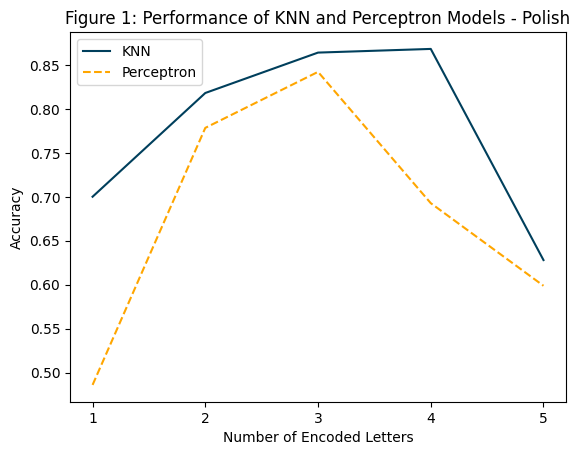

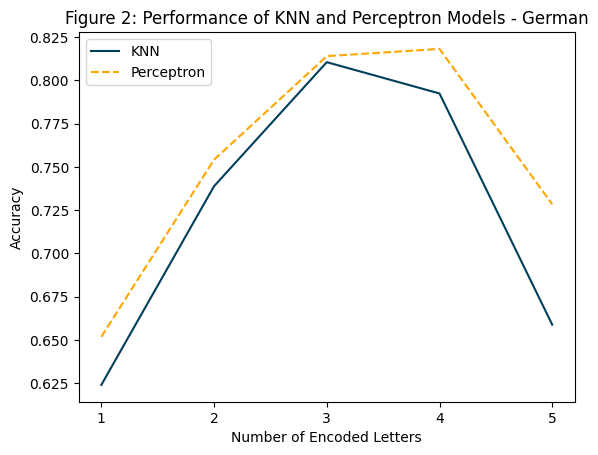

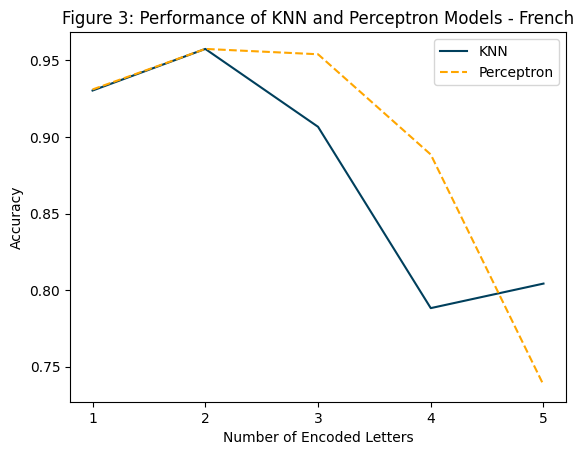

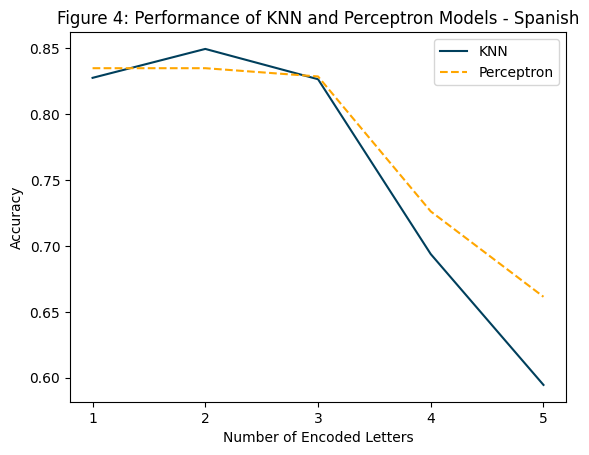

In [17]:
import matplotlib.pyplot as plt
import numpy as np

languages = ['Polish', 'German', 'French', 'Spanish']

x_axis = np.arange(1, 6)  # the number of encoded letters (first 5 columns)

# Iterate over each language
for i, language in enumerate(languages):
    knn_scores = knn_iterative_df[language].values[:5]  # Extract KNN scores for the language (first 5 columns)
    perceptron_scores = per_iterative_df[language].values[:5]  # Extract Perceptron scores for the language (first 5 columns)

    # Create a new figure and subplot for each language
    fig, ax = plt.subplots()

    ax.plot(x_axis, knn_scores, color='#003f5c', label=f'KNN')
    ax.plot(x_axis, perceptron_scores, color='#ffa600', linestyle='--', label=f'Perceptron')

    # Add labels, legend, and title for each language plot
    ax.set_xlabel('Number of Encoded Letters')
    ax.set_ylabel('Accuracy')
    ax.legend()
    ax.set_title(f'Figure {i+1}: Performance of KNN and Perceptron Models - {language}')

    # Set x-axis ticks to integers
    ax.set_xticks(x_axis)

    # Display the plot for each language
    plt.show()

In [18]:
# the optimal number of ending letters for each language and the optimal performance

def optimal(model):
    opt_results = {}
    for language in model:
        opt_performance = max(model[language])
        index = model[language].tolist().index(opt_performance)+1
        opt_results[language] = (index, opt_performance)
    return opt_results

In [19]:
print(f"Perceptron: {optimal(per_iterative_df)}")
print(f"knn: {optimal(knn_iterative_df)}")

Perceptron: {'Polish': (3, 0.8422152560083594), 'German': (4, 0.8182451253481894), 'French': (2, 0.9575208913649025), 'Spanish': (1, 0.8349007314524556)}
knn: {'Polish': (4, 0.8683385579937304), 'German': (3, 0.8105849582172702), 'French': (2, 0.9575208913649025), 'Spanish': (2, 0.8495297805642633)}


## 4.5 Expermiment 2: train on one lang, and test on a different langauage (shuffle)

In [20]:
def multi_train_per_lang_shuffle(df, max_length):
    results = defaultdict(lambda :defaultdict(lambda: defaultdict()))
    training_data = defaultdict()
    testing_data = defaultdict()
    trans_df = encode(df, max_length) # encode
    dfs = df_lang(trans_df)
    for sub_df in dfs: # for each language
        X, y = get_X_y(sub_df.df) # get X and y
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) # split
        training_data[sub_df.lang] = (X_train, y_train) # add the x and y train for each language into a dict
        testing_data[sub_df.lang] = (X_test, y_test) # add the x and y testing for each language into a dict
        
    for i in training_data: # for every language training
        for j in testing_data: # for every language testing
       
            X_train__, y_train__ = training_data[i]
            X_test__, y_test__ = testing_data[j]


            knn = KNeighborsClassifier(n_neighbors=3) # initialize a KNN
            knn.fit(X_train__, y_train__) # fit it with training
            results['KNN'][i][j] = knn.score(X_test__, y_test__) # test it
 
            p = Perceptron(random_state=42) # initialize a Perceptron
            p.fit(X_train__, y_train__) # fit it with training
            results['Perceptron'][i][j] = p.score(X_test__, y_test__) # test it

    return results

### 4.6 Run experiment on only optimal number of encoded letters

In [21]:
shuffled = multi_train_per_lang_shuffle(reduced_df, 3)
shuffled

defaultdict(<function __main__.multi_train_per_lang_shuffle.<locals>.<lambda>()>,
            {'KNN': defaultdict(<function __main__.multi_train_per_lang_shuffle.<locals>.<lambda>.<locals>.<lambda>()>,
                         {'French': defaultdict(None,
                                      {'French': 0.7972831765935214,
                                       'German': 0.40947075208913647,
                                       'Polish': 0.334958217270195,
                                       'Spanish': 0.5684430512016719}),
                          'German': defaultdict(None,
                                      {'French': 0.567398119122257,
                                       'German': 0.7952646239554317,
                                       'Polish': 0.3746518105849582,
                                       'Spanish': 0.51619644723093}),
                          'Polish': defaultdict(None,
                                      {'French': 0.16614420062695925,
           

### 4.7 show results of KNN

In [22]:
knn_shuffle_res = shuffled['KNN']
knn_shuffle_df = pd.DataFrame(knn_shuffle_res)
knn_shuffle_df.to_csv('../data/knn_res_lang_shuffle_3_encoding.csv') # save as csv
knn_shuffle_df

,French,German,Polish,Spanish
French,0.797283,0.567398,0.166144,0.585162
German,0.409471,0.795265,0.425487,0.410864
Polish,0.334958,0.374652,0.887883,0.381616
Spanish,0.568443,0.516196,0.263323,0.838036


### 4.8 Show results of Perceptron

In [23]:
percp_shuffle_res = shuffled['Perceptron']
percep_shuffle_df = pd.DataFrame(percp_shuffle_res)
percep_shuffle_df.to_csv('../data/percp_res_lang_shuffle_3_encoding.csv') # save as csv
percep_shuffle_df

,French,German,Polish,Spanish
French,0.743992,0.561129,0.447231,0.502612
German,0.411560,0.780641,0.355850,0.343315
Polish,0.349582,0.371866,0.959610,0.408078
Spanish,0.594566,0.519331,0.548589,0.779519


In [24]:
print(f"Perceptron: {optimal(percep_shuffle_df)}")
print(f"knn: {optimal(knn_shuffle_df)}")

Perceptron: {'French': (1, 0.7439916405433646), 'German': (2, 0.7806406685236769), 'Polish': (3, 0.9596100278551533), 'Spanish': (4, 0.7795193312434692)}
knn: {'French': (1, 0.7972831765935214), 'German': (2, 0.7952646239554317), 'Polish': (3, 0.887883008356546), 'Spanish': (4, 0.8380355276907001)}


## 4.9 Experiment 3: Train and test on WHOLE dataset as one

In [25]:
encoded_df = encode(reduced_df, 4) #  4 letters encoded
X, y = get_X_y(encoded_df) # X is the vector representationf for n amount of letters, y are the labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# KNN
knn = KNeighborsClassifier(n_neighbors=3) # initialize a KNN class, 3 neighbors
knn.fit(X_train, y_train) # train it 
knn_score = knn.score(X_test, y_test) # get score

# Perceptron
p = Perceptron(random_state=42) # initialize a Perceptron class, random state 42
p.fit(X_train, y_train) # train it
p_score = p.score(X_test, y_test) # get score

In [26]:
# Baseline (most frequent class)
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
baseline_score = dummy_clf.score(X_test, y_test)

### 4.10 display knn scores

In [27]:
knn_score

0.7817725752508361

### 4.11 display perceptron scores

In [28]:
p_score

0.8426003344481605

### 4.12 display baseline scores

In [29]:
baseline_score

0.40008361204013376

### 4.13 Plot performances

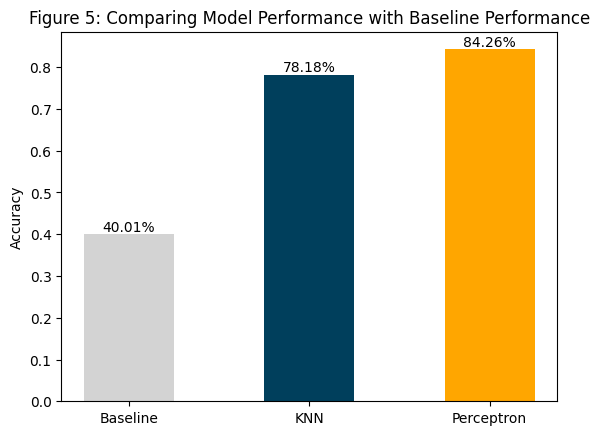

In [30]:
categories = ['Baseline', 'KNN', 'Perceptron']
performance_values = [baseline_score, knn_score, p_score]

x = np.arange(len(categories))
width = 0.5

fig, ax = plt.subplots()

# the colors for each bar
colors = ['LightGray', '#003f5c', '#ffa600']

# Plot the bars with the specified colors
bars = ax.bar(x, performance_values, width, color=colors)

ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.set_ylabel('Accuracy')
ax.set_title('Figure 5: Comparing Model Performance with Baseline Performance')

# Display the percentage value on top of each bar
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2%}', ha='center', va='bottom')

plt.show()